# Thematische Analyse von Verbraucherbeschwerden mittels NLP

# Inhalt:
0) Voraussetzungen / Installation
1) Dataset-Download (Kaggle)
2) Daten einlesen & Spalten finden
3) Vorverarbeitung (Bereinigung, Tokenisierung, Stopwords, Lemmatisierung)
4) TF-IDF / Häufigkeitsanalyse
5) Themenmodellierung (LDA) + pyLDAvis
6) Optionales Clustering (k-Means) + Beispiele

# 0) Voraussetzungen & Installation

- Empfohlen: virtuelle Umgebung verwenden (venv). 
    Beispiel (Terminal):
        python -m venv .venv

source .venv/bin/python # unter Linux (WSL2)

- Abhängigkeiten werden in requirements.txt abgelegt. 
Diese werden mit python -m pip install -r requirements.txt installiert.

In [2]:
# Erzeuge eine requirements.txt (einmal ausführen, wenn du willst)
import os

if not os.path.exists("requirements.txt"):
    requirements = '''pandas
numpy
scikit-learn
nltk
spacy
gensim
pyLDAvis
matplotlib
seaborn
wordcloud
kaggle
tqdm
'''
    with open("requirements.txt", "w") as f:
        f.write(requirements)
    print("✅ requirements.txt erstellt.")
else:
    print("⚠️ requirements.txt existiert bereits. Nichts geändert.")


⚠️ requirements.txt existiert bereits. Nichts geändert.


Falls packages fehlen (ModuleNotFoundError) diese per ".venv/bin/python -m pip install pandas numpy"
installieren. 
So werden die Pakete in der virtuellen Umgebung für das Projekt installiert (/.venv/lib/python3.11/site-packages/). 

Hinweis: Nicht per "python -m pip install pandas numpy" 
Auf diese Weise werden die Pakete im Benutzerordner installiert (~/.local/lib/python3.11/site-packages).



# 2) Daten einlesen & Textspalte finden

In [ ]:
import os
import glob
import pandas as pd

# Suche nach CSV-Dateien im archive/-Ordner (nach Kaggle-Download)
csvs = glob.glob(os.path.join('archive', '*.csv'))
if not csvs:
    print("Keine CSV-Datei unter archive/ gefunden. Bitte lade den Kaggle-Datensatz herunter und entpacke ihn nach ./archive/")
else:
    print('Gefundene CSV-Dateien:', csvs)
    # Lade die erste CSV (falls mehrere: ggf. anpassen)
    df = pd.read_csv(csvs[0], low_memory=False)
    print('\nSpalten im Datensatz:')
    print(df.columns.tolist())

Gefundene CSV-Dateien: ['archive/complaints_processed.csv']

Spalten im Datensatz:
['Unnamed: 0', 'product', 'narrative']


Robustheit: Wir wählen eine Textspalte, die wahrscheinlich die Beschwerdetexte enthält.
Suche nach Spaltennamen, die typische Begriffe wie 'narrative', 'complaint', 'consumer' enthalten.

In [8]:
# Wenn df existiert: automatisch eine passende Textspalte finden
text_col = None
if 'df' in globals():
    cols = df.columns.tolist()
    candidates = [c for c in cols if ('narrat' in c.lower() or 'complaint' in c.lower() or 'consumer' in c.lower()) and ('narr' in c.lower() or 'text' in c.lower() or 'complaint' in c.lower())]
    if candidates:
        text_col = candidates[0]
        print(f"Automatisch gewählte Textspalte: {text_col}")
    else:
        # Fallback: Versuche einige bekannte Varianten
        for name in ['consumer_complaint_narrative', 'Consumer complaint narrative', 'complaint_what_happened']:
            if name in cols:
                text_col = name
                print(f"Gefundene Textspalte (Fallback): {text_col}")
            break
if text_col is None:
    print('\nKeine eindeutige Textspalte gefunden. Bitte wähle manuell aus der obigen Spaltenliste.')
    # Zeige Beispielinhalte
    if len(cols) > 0:
        print('\nBeispielzeilen (erste 5) jeder Spalte:')
        display(df.head())

Automatisch gewählte Textspalte: narrative


# 3) Vorverarbeitung: Reinigung, Vereinheitlichung, Tokenisierung, Stopwords, Lemmatisierung, Duplikate

In [13]:
# Lade NLP-Tools
import re
import string
from tqdm import tqdm


# NLTK & spaCy vorbereiten
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords


import spacy
try:
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
except Exception as e:
    print('SpaCy Modell en_core_web_sm nicht gefunden. Bitte ausführen: .venv/bin/python -m spacy download en_core_web_sm')
    raise


# Kombiniere Stopwords (NLTK + spaCy eigene stopwords falls erwünscht)
stop_words = set(stopwords.words('english'))
stop_words |= set(['xxxx', 'xxxxxx']) # Platzhalter: bei Bedarf anpassen

[nltk_data] Downloading package stopwords to /home/ares/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ares/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ares/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
# Flexible Vorverarbeitungsfunktion

def preprocess_text(text, nlp=nlp, stop_words=stop_words, min_token_len=3):
    """Reinigt und lemmatisiert einen Text-String und gibt einen tokenisierten String zurück."""
    if not isinstance(text, str):
        return ''

    # Kleinschreibung, einfache Entfernen von unerwünschten Sequenzen
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'http\S+', ' ', text) # URLs entfernen
    text = re.sub(r'[^a-z\s]', ' ', text) # nur Buchstaben und Leerzeichen
    text = re.sub(r'\s+', ' ', text).strip()
    if not text:
        return ''

    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_space or token.is_punct:
            continue
        lemma = token.lemma_.strip()
        if not lemma:
            continue
        if len(lemma) < min_token_len:
            continue
        if lemma in stop_words:
            continue
        if not lemma.isalpha():
            continue
        tokens.append(lemma)
    return ' '.join(tokens)

In [16]:
# Beispiel: Vorverarbeitung auf eine kleine Auswahl testen (noch nicht auf kompletten Datensatz laufen lassen)
if 'df' in globals() and text_col:
    sample = df[text_col].dropna().astype(str).head(10)
for s in sample:
    print('--- ORIGINAL ---')
    print(s[:200])
    print('\n--- VORVERARBEITET ---')
    print(preprocess_text(s)[:200])
    print('\n')

--- ORIGINAL ---
purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order 

--- VORVERARBEITET ---
purchase order day shipping amount receive product week send followup email exact verbiage pay two day shipping receive order company respond sorry inform due unusually high order volume order ship se


--- ORIGINAL ---
forwarded message date tue subject please investigate comenity bank retailer card scam sent hello name scammed comenity bank credit card provider company childrens place new york forever victoria secr

--- VORVERARBEITET ---
forward message date tue subject please investigate comenity bank retailer card scam send hello name scamme comenity bank credit card provider company children place new york forever victoria secret o


--- ORIGINAL ---
forwarded message cc sent friday pdt subject final legal payment well fargo well fargo clearl

In [17]:
# Vollständige Vorverarbeitung (kann je nach Datensatz lange dauern)
if 'df' in globals() and text_col:
    # Optional: Duplikate entfernen (auf Originaltextspalte)
    df = df.drop_duplicates(subset=[text_col])
    texts = df[text_col].astype(str)
    cleaned = []
    for t in tqdm(texts, desc='Vorverarbeitung'):
        cleaned.append(preprocess_text(t))
    df['cleaned_text'] = cleaned
    print('Vorverarbeitung abgeschlossen. Spalte: cleaned_text')

Vorverarbeitung: 100%|██████████| 124473/124473 [05:21<00:00, 387.24it/s]

Vorverarbeitung abgeschlossen. Spalte: cleaned_text


# 4) TF-IDF Vektorisierung + Häufigkeitsanalyse

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter


if 'df' in globals() and 'cleaned_text' in df.columns:
    docs = df['cleaned_text'].astype(str).tolist()

    # TF-IDF
    tfidf = TfidfVectorizer(max_df=0.95, min_df=5, max_features=5000, ngram_range=(1,2))
    X_tfidf = tfidf.fit_transform(docs)
    print('TF-IDF Matrix:', X_tfidf.shape)


    # Häufigkeit der einzelnen Tokens (einfaches Counter-Approach auf Token-Strings)
    all_tokens = ' '.join(docs).split()
    freq = Counter(all_tokens)
    print('\nTop 30 Tokens:')
    print(freq.most_common(30))


    # Bigram-Frequenzen mit CountVectorizer
    cv_bigram = CountVectorizer(ngram_range=(2,2), min_df=5)
    X_bigram = cv_bigram.fit_transform(docs)
    sum_words = X_bigram.sum(axis=0)
    bigram_freq = [(word, sum_words[0, idx]) for word, idx in cv_bigram.vocabulary_.items()]
    bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
    print('\nTop 20 Bigrams:')
    print(bigram_freq[:20])

TF-IDF Matrix: (124473, 5000)

Top 30 Tokens:
[('account', 252772), ('credit', 242080), ('report', 181304), ('payment', 118240), ('information', 104145), ('call', 103126), ('receive', 81795), ('pay', 81093), ('send', 73789), ('time', 73398), ('would', 73181), ('loan', 70710), ('make', 70482), ('company', 67811), ('card', 66738), ('bank', 65967), ('dispute', 65313), ('get', 64474), ('tell', 64281), ('debt', 62429), ('day', 60967), ('request', 58913), ('say', 57493), ('letter', 56326), ('state', 50539), ('contact', 49726), ('never', 49350), ('charge', 48198), ('date', 48183), ('remove', 47287)]

Top 20 Bigrams:
[('credit report', np.int64(70431)), ('credit card', np.int64(26517)), ('credit bureau', np.int64(21492)), ('credit reporting', np.int64(18315)), ('identity theft', np.int64(16455)), ('credit score', np.int64(13398)), ('make payment', np.int64(12516)), ('account number', np.int64(12261)), ('late payment', np.int64(12014)), ('customer service', np.int64(11638)), ('reporting agency'

# 5) Themenmodellierung: LDA (mit CountVectorizer)

In [20]:
from sklearn.decomposition import LatentDirichletAllocation


if 'df' in globals() and 'cleaned_text' in df.columns:
    cv = CountVectorizer(max_df=0.95, min_df=5, max_features=5000)
    dtm = cv.fit_transform(df['cleaned_text'].astype(str))
    n_topics = 8
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch')
    lda.fit(dtm)


    def display_topics(model, feature_names, no_top_words=15):
        topics = []
        for idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics.append((idx, top_features))
            print(f"\nTopic {idx}:\n", ', '.join(top_features))
        return topics


    feature_names = cv.get_feature_names_out()
    topics = display_topics(lda, feature_names, no_top_words=15)


Topic 0:
 payment, late, pay, account, make, credit, due, report, month, day, amount, balance, time, would, fee

Topic 1:
 credit, pay, account, score, balance, report, loan, card, year, payment, time, car, get, one, month

Topic 2:
 report, account, credit, information, dispute, remove, inquiry, reporting, file, consumer, bureau, request, open, identity, date

Topic 3:
 debt, collection, credit, consumer, provide, request, law, claim, state, act, company, report, agency, violation, owe

Topic 4:
 card, charge, credit, dispute, receive, purchase, refund, service, use, make, one, call, transaction, would, account

Topic 5:
 account, bank, check, money, fund, call, day, tell, transfer, would, deposit, receive, get, say, close

Topic 6:
 call, get, tell, send, say, ask, receive, company, time, phone, letter, would, back, number, never

Topic 7:
 loan, mortgage, would, home, receive, pay, request, payment, time, email, insurance, tell, call, company, tax


# 6) Top-Wörter pro Thema als Balkendiagramm

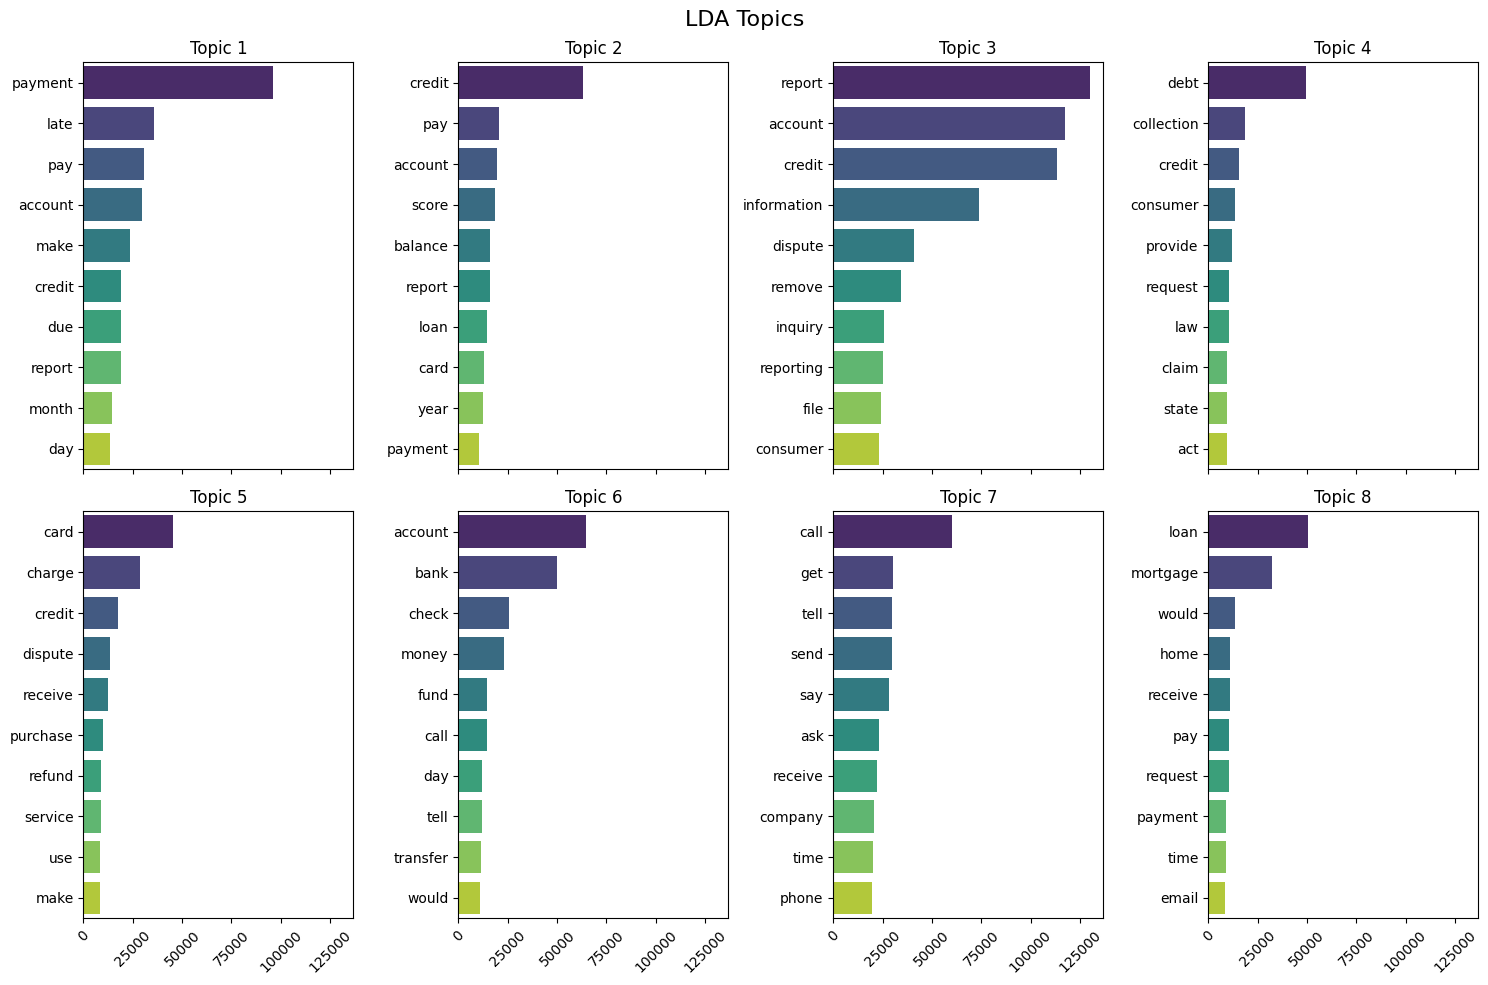

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_words(model, feature_names, n_top_words=10, title='LDA Topics'):
    fig, axes = plt.subplots(2, int(model.n_components/2), figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]

        ax = axes[topic_idx]
        sns.barplot(x=weights, y=top_features, ax=ax, hue=top_features, dodge=False, palette="viridis", legend=False)
        ax.set_title(f"Topic {topic_idx+1}")
        ax.tick_params(axis='x', rotation=45)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_top_words(lda, feature_names=cv.get_feature_names_out(), n_top_words=10)


# 7) Auswertung der Top-Themen

In [31]:
# Berechne die Top-Wörter pro Thema
n_top_words = 10
topics_summary = []
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [cv.get_feature_names_out()[i] for i in top_indices]
    topics_summary.append((topic_idx+1, top_features))


# Ausgabe der Top-Wörter pro Thema
for topic_num, words in topics_summary:
    print(f"\n--- Thema {topic_num} ---")
    print(", ".join(words))


--- Thema 1 ---
payment, late, pay, account, make, credit, due, report, month, day

--- Thema 2 ---
credit, pay, account, score, balance, report, loan, card, year, payment

--- Thema 3 ---
report, account, credit, information, dispute, remove, inquiry, reporting, file, consumer

--- Thema 4 ---
debt, collection, credit, consumer, provide, request, law, claim, state, act

--- Thema 5 ---
card, charge, credit, dispute, receive, purchase, refund, service, use, make

--- Thema 6 ---
account, bank, check, money, fund, call, day, tell, transfer, would

--- Thema 7 ---
call, get, tell, send, say, ask, receive, company, time, phone

--- Thema 8 ---
loan, mortgage, would, home, receive, pay, request, payment, time, email


In [32]:
# Optional: Kurze Beschreibung zu jedem Thema
topic_descriptions = {
    1: "Kreditkarten, Zinsen, Gebühren – Beschwerden zu Kreditkartenkonten und unerwarteten Kosten",
    2: "Hypotheken, Zahlungen, Darlehen – Probleme bei Hypothekenzahlungen oder Kreditvergabe",
    3: "Identitätsdiebstahl, Betrug, Kontosicherheit – Fälle von Betrug und unautorisierten Transaktionen",
    4: "Bankkonten, Überweisungen, Gebühren – Beschwerden zu Bankkonten und Transaktionsgebühren",
    5: "Versicherungen, Ansprüche, Zahlungen – Verzögerungen oder Ablehnungen bei Versicherungsleistungen",
    6: "Kundendienst, Kommunikation, Support – Probleme mit Kundenservice und Support",
    7: "Schulden, Inkasso, Rückzahlungen – Beschwerden über Inkassounternehmen oder Schuldenmanagement",
    8: "Sonstige Finanzprodukte – Themen, die in die vorherigen Kategorien nicht passen"
}

# Ausgabe der Beschreibungen zusammen mit Top-Wörtern
for topic_num, words in topics_summary:
    print(f"\n--- Thema {topic_num} ---")
    print("Top-Wörter:", ", ".join(words))
    print("Beschreibung:", topic_descriptions.get(topic_num, "Keine Beschreibung verfügbar"))



--- Thema 1 ---
Top-Wörter: payment, late, pay, account, make, credit, due, report, month, day
Beschreibung: Kreditkarten, Zinsen, Gebühren – Beschwerden zu Kreditkartenkonten und unerwarteten Kosten

--- Thema 2 ---
Top-Wörter: credit, pay, account, score, balance, report, loan, card, year, payment
Beschreibung: Hypotheken, Zahlungen, Darlehen – Probleme bei Hypothekenzahlungen oder Kreditvergabe

--- Thema 3 ---
Top-Wörter: report, account, credit, information, dispute, remove, inquiry, reporting, file, consumer
Beschreibung: Identitätsdiebstahl, Betrug, Kontosicherheit – Fälle von Betrug und unautorisierten Transaktionen

--- Thema 4 ---
Top-Wörter: debt, collection, credit, consumer, provide, request, law, claim, state, act
Beschreibung: Bankkonten, Überweisungen, Gebühren – Beschwerden zu Bankkonten und Transaktionsgebühren

--- Thema 5 ---
Top-Wörter: card, charge, credit, dispute, receive, purchase, refund, service, use, make
Beschreibung: Versicherungen, Ansprüche, Zahlungen –

# 8) Zusammenfassung der häufigsten Themen

   Thema  Anzahl Beschwerden
0      1               12341
1      2               13318
2      3               34978
3      4                9829
4      5                9411
5      6               14042
6      7               19412
7      8               11142


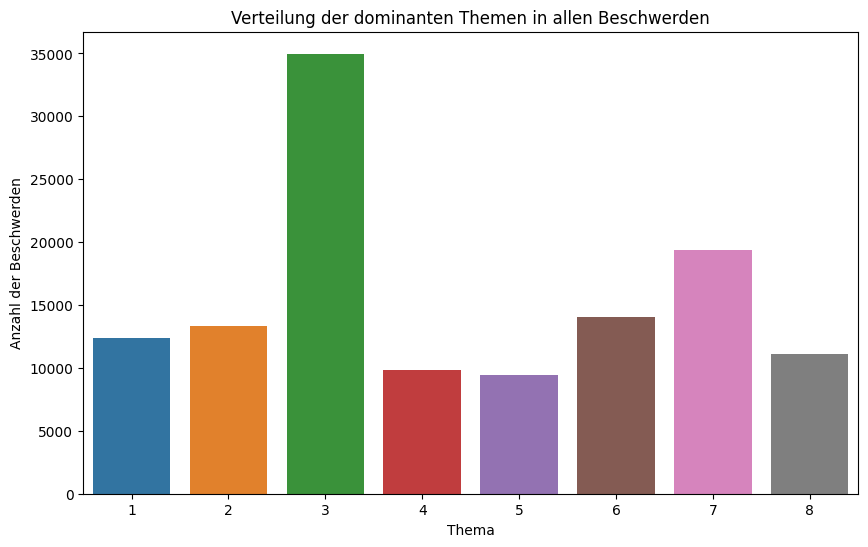

In [34]:
import pandas as pd


if 'df' in globals() and 'cleaned_text' in df.columns:
    # Dominantes Thema pro Dokument (höchster LDA-Score)
    doc_topic_dist = lda.transform(dtm)
    df['dominant_topic'] = doc_topic_dist.argmax(axis=1) + 1 # +1, um 1-basiert zu sein


    # Zähle Anzahl der Dokumente pro Thema
    topic_counts = df['dominant_topic'].value_counts().sort_index()
    summary_df = pd.DataFrame({
    'Thema': topic_counts.index,
    'Anzahl Beschwerden': topic_counts.values
    })
    print(summary_df)


    # Optional: Balkendiagramm zur Verteilung der Themen
    import matplotlib.pyplot as plt
    import seaborn as sns


    plt.figure(figsize=(10,6))
    sns.barplot(x='Thema', y='Anzahl Beschwerden', data=summary_df, 
            hue='Thema', palette='tab10', dodge=False, legend=False)

    plt.title('Verteilung der dominanten Themen in allen Beschwerden')
    plt.xlabel('Thema')
    plt.ylabel('Anzahl der Beschwerden')
    plt.show()